In [1]:
# https://www.kaggle.com/code/papeloto/urban-sound-feature-extraction-knn/notebook
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import IPython.display as ipd

import librosa
import librosa.display
import soundfile as sf # librosa fails when reading files on Kaggle.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
audio_path = "1.wav"
ipd.Audio(audio_path)

In [3]:
x, sr = librosa.load(audio_path)

In [4]:
x.shape, sr

((739329,), 22050)

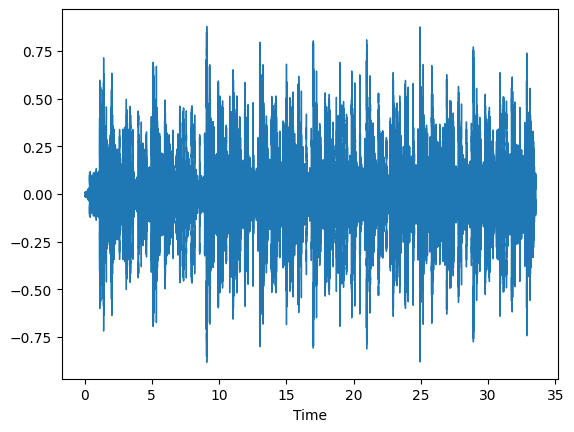

In [6]:
plt.figure()
librosa.display.waveshow(x, sr=sr)
plt.show()

Number of crosses: 16


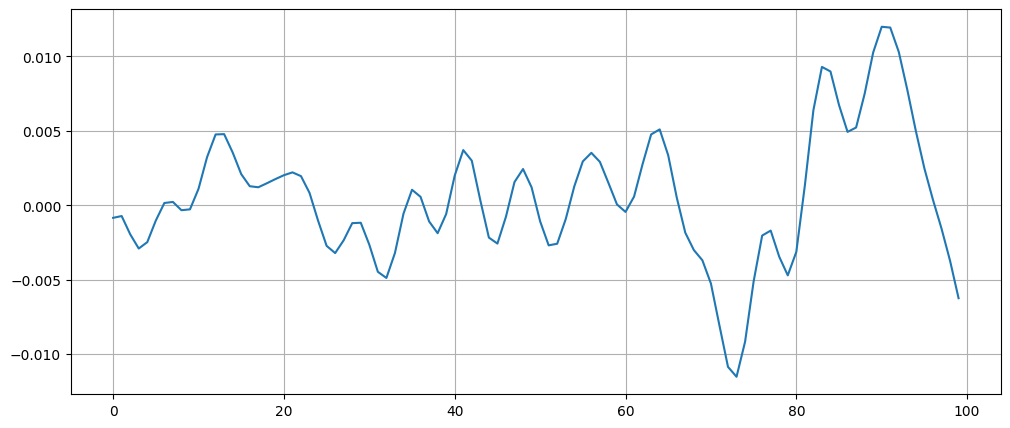

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(x[1000:1100]) # Zoom-in for seeing the example.
plt.grid()

n_crossings = librosa.zero_crossings(x[1000:1100], pad=False)
print(f'Number of crosses: {sum(n_crossings)}')



In [9]:
centroids = librosa.feature.spectral_centroid(y=x, sr=sr)[0]

print(f'Centroids Shape: {centroids.shape}')
print(f'First 3 centroids: {centroids[:3]}')

Centroids Shape: (1445,)
First 3 centroids: [1399.18223064 1434.33305733 1501.55855652]


MFFCs shape: (20, 1445)
First mffcs: [-428.85718 -401.3687  -394.06415 -386.5262  -382.21503]


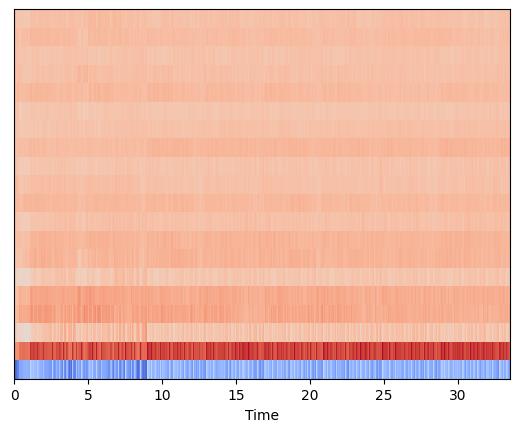

In [11]:
mfccs = librosa.feature.mfcc(y=x, sr=sr)
print(f'MFFCs shape: {mfccs.shape}')
print(f'First mffcs: {mfccs[0, :5]}')

# We can even display an spectogram of the mfccs.
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()



In [76]:

def mean_mfccs(x):
    return [np.mean(feature) for feature in librosa.feature.mfcc(y=x)]

def parse_audio(x):
    return x.flatten('F')[:x.shape[0]] 

def get_audios(df):
    train_path = "input/audio"
    samples = []
    classes = []
    paths = []
    
    N = 1000
    i = 0
    
    for root, dirs, files in os.walk(train_path):
        for file in files:
            if not file.endswith(".wav"):
                continue
            fpath = root + "/" + file
            paths.append(fpath)
            
            x, sr = sf.read(fpath, always_2d=True)
            x = parse_audio(x)
            samples.append(mean_mfccs(x))
            
            c = df.loc[df['slice_file_name'] == file]['class'].values
#             print(c)
            classes.append(c)
            
            
            i += 1
            
            if i >= N:
                break
            
        if i >= N:
            break
        
    return (np.array(samples), np.array(classes), paths)

def get_samples():
    df = pd.read_csv('input/metadata/UrbanSound8K.csv')
#     ipd.display(df)
#     print(df.loc[df['slice_file_name'] == '100263-2-0-117.wav'])
#     return get_audios(), df['Class'].values
    return get_audios(df)



In [77]:
X, Y, paths = get_samples()

In [67]:
Y[0]

array(['siren'], dtype=object)

In [69]:
ipd.Audio(paths[0])

In [78]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)

In [79]:


print(f'Shape: {x_train.shape}')
print(f'Observation: \n{x_train[0]}')
print(f'Labels: {y_train[:5]}')



Shape: (750, 20)
Observation: 
[-1.47389829e+02  7.12084112e+01 -2.24959264e+01  3.04148490e+01
 -2.37381186e+01  1.69961438e+01  1.34883949e+01  1.06088045e+01
 -2.13060437e+01  3.70402927e+00  4.32839031e+00 -3.02459001e+00
  1.22888954e+00 -2.46974715e+00 -6.50100037e+00  2.69238170e-02
 -7.55202170e-01  6.18640429e+00 -3.75339952e+00  3.47480239e+00]
Labels: [['jackhammer']
 ['dog_bark']
 ['siren']
 ['air_conditioner']
 ['drilling']]


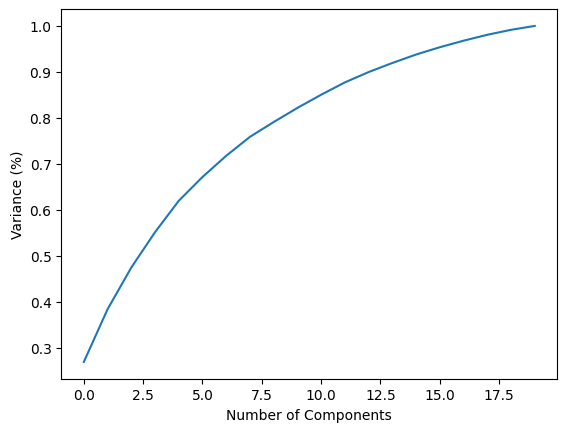

In [80]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

pca = PCA().fit(x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()

In [81]:
grid_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

model = GridSearchCV(KNeighborsClassifier(), grid_params, cv=5, n_jobs=-1)
model.fit(x_train_scaled, y_train)

/home/op/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/op/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/op/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/op/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed 

/home/op/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/op/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/op/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/op/miniconda3/envs/torch/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']})

In [82]:
print(f'Model Score: {model.score(x_test_scaled, y_test)}')

y_predict = model.predict(x_test_scaled)
print(f'Confusion Matrix: \n{confusion_matrix(y_predict, y_test)}')

Model Score: 0.924
Confusion Matrix: 
[[27  0  0  2  0  0  0  0  0  0]
 [ 0 12  0  0  0  0  0  0  0  0]
 [ 0  0 21  3  2  0  1  0  0  1]
 [ 0  1  0 22  0  0  1  0  0  0]
 [ 0  0  0  0 31  0  0  0  0  0]
 [ 0  0  0  0  0 28  0  0  0  0]
 [ 0  0  1  3  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0]
 [ 0  0  0  1  0  1  0  0 32  0]
 [ 0  1  0  0  0  0  0  0  1 25]]
